# Evolution du bruit médian en France depuis le début de la pandémie

> Ce Notebook présente lévolution du bruit médian en France depuis lde début de l'épidémie

---
## Importation des modules

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings
from scipy import optimize

try:
    os.environ["PROJ_LIB"] = r'/home/flavien/anaconda3/envs/SeismicNoise2A/share/basemap/'
except:
    pass
from mpl_toolkits.basemap import Basemap


from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
## Paramètre initiaux

In [2]:
PPSD_FOLDER  = "/media/flavien/Stockage/SeismicNoiseData/PPSD"
DRMS_FOLDER  = "/media/flavien/Stockage/SeismicNoiseData/DRMS"
MSEED_FOLDER = "/media/flavien/Stockage/SeismicNoiseData/MSEED"
DATA_FOLDER  = "DATA"
freqs = [(0.01, 0.03), (0.1, 0.25), (0.3, 1), (1, 3), (5, 15), (20, 50)] # Bandes de fréquences à étudier
freq = "1.0-3.0"

tStart = "2020-01-01"
tEnd   = "2021-08-01"

# list_stations = ["FR.STR.00.HHZ", "FR.CURIE.00.HHZ", "FR.BRGF.00.HHZ"]
list_stations = np.loadtxt(DATA_FOLDER + "/st_metadata/stations_fr.txt", dtype=str)

In [3]:
events = {
    "Lockdown 1" :      "2020-03-17",
    "Lockdown 1 exit" : "2020-05-11",
    "Lockdown 2" :      "2020-10-30",
    "Lockdown 2 exit" : "2020-12-15",
    "Christmas" :       "2020-12-25",
    "New Year" :        "2021-01-01",
    "Curfew 18h-6h" :   "2021-01-16",
    "Lockdown 3" :      "2021-04-03"
}

---
## Calcul de la médiane pour chaque station

On calcul les PPSDs sur l'ensemble des périodes d'un mois (1 mois pendant le confinement, 1 mois hors confinement). Toutes les données sont stockées dans le dictionnaire `ppsds`.

In [4]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [5]:
med_values = []

for j, st_str in tqdm.tqdm(enumerate(list_stations)):
    # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

    ### Calcul du déplacement RMS de la station
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dataframe.index=pd.to_datetime(dataframe.index)
        dRMS = dataframe
    except:
        continue
        
    ### On garde les données dans la période temporelle qui nous intéresse
    mask_time = (dataframe.index > tStart) & (dataframe.index <= tEnd)
    dRMS = dRMS.loc[mask_time]
    
    ### Récupération du bruit
    dRMS_med = dRMS[freq].between_time("6:00", "16:00").resample("1D").median()
    dRMS_med = dfDates.join(dRMS_med, how='outer')
    

    ### Mise en graphique
    color = "#353535"
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.tick_params(direction="in", which="both", top=True, right=True)
    ax.set_title("Frequency band : {}Hz | {}".format(freq, st_str))
    ax.plot(dRMS_med, color=color, lw=2, zorder=3)
    plt.ylim(-1*np.nanquantile(dRMS_med, 0.01), 1.5*np.nanquantile(dRMS_med, 0.99))
    ax.set_xlim([dates[0], dates[-1]])
    ax.set_xlabel("Year 2020")
    ax.set_ylabel("Median displacement [m]")

    for desc, t_search in events.items():
        t_search = pd.Timestamp(t_search)
        t_text = t_search - pd.Timedelta("5 days")
        ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
        ax.text(t_text, -0.85*np.nanquantile(dRMS_med, 0.01), desc, color="#396790", fontsize="medium", rotation=90)   # Confinement 1

    plt.grid(color="#D5D5D5", linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.savefig("RESULTS/FR_2020/noise_stations/{}_{}.png".format(st_str, freq), dpi=300)
    # plt.show()
    plt.close()
    plt.clf()

    ### Normalisation du bruit
    dRMS_med = dRMS_med[freq].tolist()
    norm = np.nanmedian(dRMS_med)
    dRMS_med = dRMS_med/norm
    med_values.append(dRMS_med)

138it [01:14,  1.84it/s]


<Figure size 432x288 with 0 Axes>

In [6]:
print("Dimensions de la matrice :", np.shape(med_values))

Dimensions de la matrice : (130, 578)


---
## Calcul de la médiane de toutes les stations

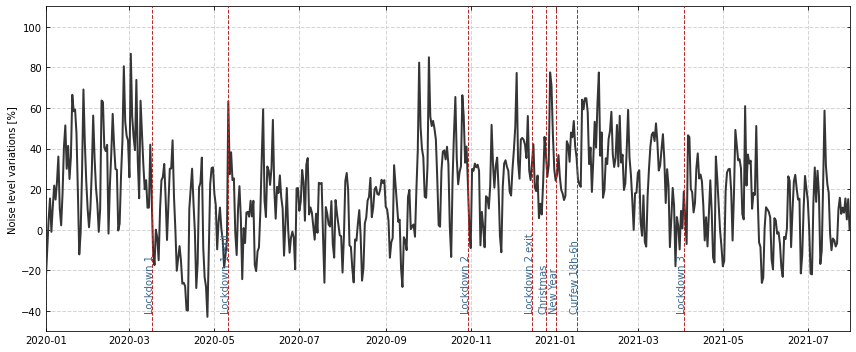

Références de normalisation sur l'année : 2020-01-15 00:00:00 - 2020-03-10 00:00:00


In [9]:
noise_fr = np.zeros(nDays)

for i in range(nDays):
    
    sublist = list()
    
    for j in range(np.shape(med_values)[0]):
        sublist.append(med_values[j][i])
    
    noise_fr[i] = np.nanmedian(sublist)

norm_period = ["2020-01-15", "2020-03-10"]
t1_i = np.where(dates >= pd.Timestamp(norm_period[0]))[0][0]
t2_i = np.where(dates >= pd.Timestamp(norm_period[1]))[0][0]
norm = (np.nanmedian(noise_fr[t1_i:t2_i])-1)*100  # Normaliser à 0 sur la période Mi-Janvier > Mi-Mars
noise_fr = (noise_fr-1)*100+norm
    
color = "#353535"
fig, ax = plt.subplots(figsize=(12, 5))
ax.tick_params(direction="in", which="both", top=True, right=True)
# ax.set_title("Frequency band : {}Hz".format(freq))
ax.plot(dates, noise_fr, color=color, lw=2, zorder=3)
# plt.ylim(1.7*np.nanquantile(noise_fr, 0.01), 1.5*np.nanquantile(noise_fr, 0.99))
plt.ylim(-50, 110)
ax.set_xlim([dates[0], dates[-1]])
# ax.set_xlabel("Year 2020")
ax.set_ylabel("Noise level variations [%]")

for desc, t_search in events.items():
    t_search = pd.Timestamp(t_search)
    t_text = t_search - pd.Timedelta("5 days")
    ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
    ax.text(t_text, -40, desc, color="#396790", fontsize="medium", rotation=90)   # Confinement 1


plt.grid(color="#D5D5D5", linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig("RESULTS/FR_2020/noise_FR_{}.png".format(freq), dpi=300)
plt.show()

print("Références de normalisation sur l'année : {} - {}".format(dates[t1_i],dates[t2_i]))

---
## Cartes de diminution du bruit